In [1]:
import os

import geopandas as gpd
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("dark_background")

In [17]:
# read in trade OD matrix

root_dir = ".."

od_dir = os.path.join(root_dir, "results/input/trade_matrix")
od = pd.read_parquet(os.path.join(od_dir, "trade_nodes_total.parquet"))
print(f"OD has {len(od):,d} flows")

# read in edges and filter out OD flows we certainly can't route to
edges = gpd.read_parquet(os.path.join(root_dir, "results/multi-modal_network/edges.gpq"))
available_destinations = edges[edges["mode"] == "imaginary"].to_id.unique()
available_country_destinations = [d.split("_")[-1] for d in available_destinations if d.startswith("GID_")]

# read nodes to plot where these flows are related to in THA
nodes = gpd.read_parquet(os.path.join(root_dir, "results/multi-modal_network/nodes.gpq"))

OD has 21,431,475 flows


In [18]:
# country boundaries for diagnostic plotting
countries = gpd.read_parquet(os.path.join(root_dir, "results/input/admin-boundaries/admin-level-0.geoparquet"))

In [19]:
country_volume_total = od.loc[:, ["partner_GID_0", "volume_tons"]].groupby("partner_GID_0").sum()
country_volume_total.index.name = "GID_0"

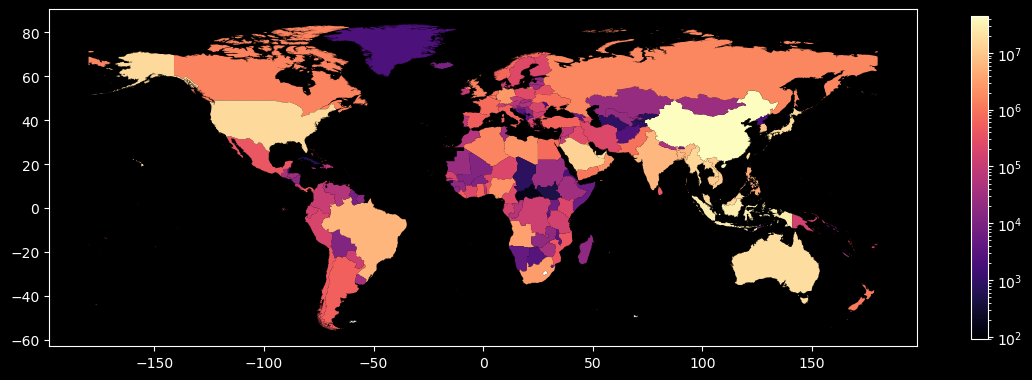

In [20]:
f, ax = plt.subplots(figsize=(14, 7))
to_plot = countries.set_index("GID_0").join(country_volume_total)
cmap = plt.get_cmap("magma")
cmap.set_under("white")
to_plot.plot(
    "volume_tons",
    ax=ax,
    cmap=cmap,
    legend=True,
    norm=matplotlib.colors.LogNorm(
        vmin=to_plot.volume_tons.max(),
        vmax=1E2
    ),
    legend_kwds={
        "shrink": 0.6
    },
)
f.savefig("od_countries_log.png")

In [6]:
leading_partners = od.loc[:, ["partner_GID_0", "volume_tons"]].groupby("partner_GID_0").sum()\
    .sort_values("volume_tons", ascending=False)[:10].index.values
vmax = np.log10(od.volume_tons.quantile(.99))
for iso_a3_code in leading_partners:
    node_tonnage = od.loc[od.partner_GID_0==iso_a3_code, ["id", "volume_tons"]].groupby("id").sum()
    node_tonnage.index = node_tonnage.index.to_series().apply(lambda s: f"road_{s}").values
    nodes_with_tonnage = nodes.set_index("id").join(node_tonnage, how="inner")
    f, ax = plt.subplots(figsize=(6, 8))
    nodes_with_tonnage.plot(
        np.log10(nodes_with_tonnage.volume_tons),
        legend=True,
        ax=ax,
        s=0.1,
        alpha=0.9,
        vmin=1,
        vmax=vmax,
        legend_kwds={"label": "log10(volume)"}
    )
    ax.set_title(f"Trade with {iso_a3_code}: {nodes_with_tonnage.volume_tons.sum():.1E} tons/a")
    ax.set_xlabel("Longitude [deg]")
    ax.set_ylabel("Latitude [deg]")
    ax.set_xlim(97, 106)
    ax.set_ylim(5, 21.5)
    f.savefig(f"plots/node_to_partner/{iso_a3_code}.png")
    plt.close(f)

<Axes: >

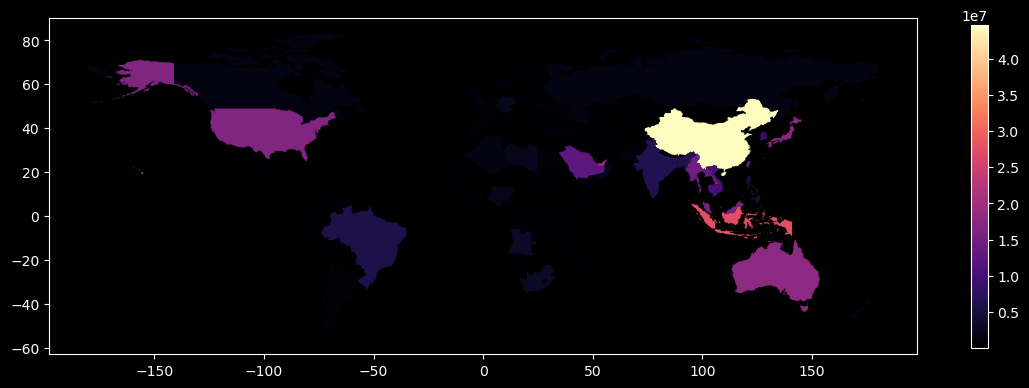

In [7]:
f, ax = plt.subplots(figsize=(14, 7))
to_plot = countries.set_index("GID_0").join(country_volume_total)
cmap = plt.get_cmap("magma")
cmap.set_under("white")
to_plot.plot(
    "volume_tons",
    ax=ax,
    cmap=cmap,
    legend=True,
    legend_kwds={
        "shrink": 0.6
    },
)

In [8]:
total_volume_tonnes = od.volume_tons.sum()
by_country = to_plot.loc[:, ["volume_tons"]].copy()
by_country = by_country.sort_values("volume_tons", ascending=False)
by_country = by_country[~by_country.volume_tons.isna()]

# country partnerships required for 90% of trade volume
important_partners = by_country[by_country.volume_tons.cumsum() / total_volume_tonnes < 0.9]
important_partners.head(10)

,volume_tons
GID_0,
CHN,4.474680e+07
IDN,2.750208e+07
ARE,1.905759e+07
AUS,1.798173e+07
JPN,1.762128e+07
USA,1.666831e+07
MYS,1.563507e+07
TWN,1.475055e+07
MMR,1.457195e+07


<Axes: xlabel='GID_0'>

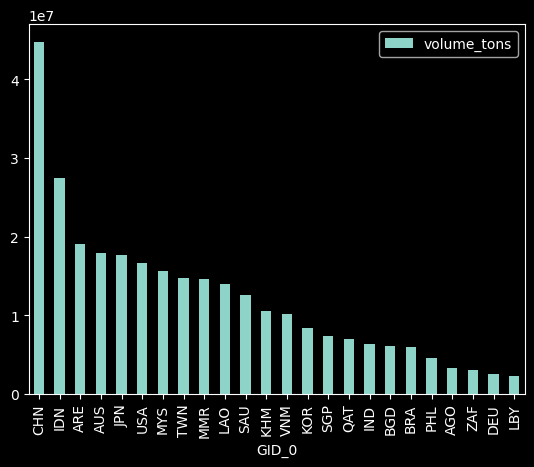

In [9]:
important_partners.plot(kind="bar")

Text(0.5, 0, 'Trade volume [t / a]')

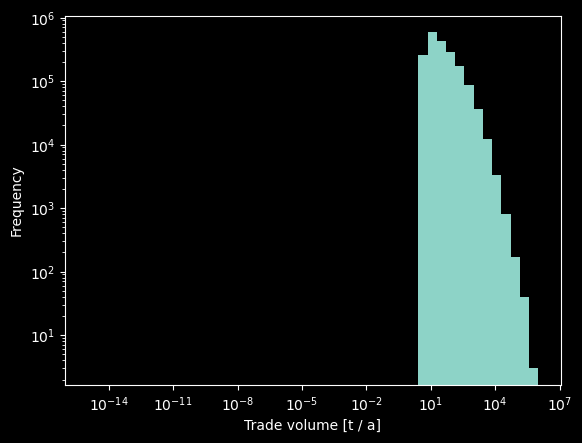

In [10]:
f, ax = plt.subplots()
ax.hist(od.volume_tons.values, bins=np.logspace(-15, 6, 50))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Frequency")
ax.set_xlabel("Trade volume [t / a]")

Text(0.5, 0, 'Trade value [k$ / a]')

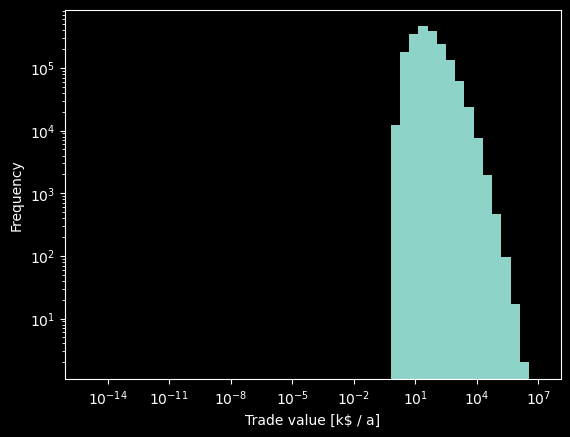

In [11]:
f, ax = plt.subplots()
ax.hist(od.value_kusd.values, bins=np.logspace(-15, 7, 50))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Frequency")
ax.set_xlabel("Trade value [k$ / a]")

In [12]:
# original OD has ~21M pairs
# let's drop any pair with a volume of less than x tons
threshold_t = 5
to_plot = od
to_plot = to_plot[to_plot.volume_tons > threshold_t]
print(f"Removing pairs with volume <{threshold_t} tons\n")
print("\tTotal before\tTotal after\tChange")
print(
    f"Volume\t{od.volume_tons.sum():1.2E}"
    f"\t{to_plot.volume_tons.sum():1.2E}"
    f"\t{100 * (to_plot.volume_tons.sum() - od.volume_tons.sum()) / to_plot.volume_tons.sum():1.2f}%"
)
print(
    f"Value\t{od.value_kusd.sum():1.2E}"
    f"\t{to_plot.value_kusd.sum():1.2E}"
    f"\t{100 * (to_plot.value_kusd.sum() - od.value_kusd.sum()) / to_plot.value_kusd.sum():1.2f}%"
)
print(f"\n{len(od)=}")
print(f"{len(to_plot)=}")

Removing pairs with volume <5 tons

	Total before	Total after	Change
Volume	3.27E+08	3.27E+08	0.00%
Value	5.74E+08	5.74E+08	0.00%

len(od)=1860724
len(to_plot)=1860724


In [13]:
to_plot

,id,THA_GID_1,partner_GID_0,value_kusd,volume_tons,GID_1
231,thailand-latest_14_1060,THA.10_1,ARE,5.958418,8.921528,THA.10_1
237,thailand-latest_14_1060,THA.10_1,AUS,10.831574,15.529106,THA.10_1
255,thailand-latest_14_1060,THA.10_1,BRA,8.044474,14.040133,THA.10_1
265,thailand-latest_14_1060,THA.10_1,CHN,85.528901,55.493995,THA.10_1
318,thailand-latest_14_1060,THA.10_1,IDN,9.702360,15.393054,THA.10_1
...,...,...,...,...,...,...
21430557,thailand-latest_43_125,THA.9_1,TWN,279.253313,112.164923,THA.9_1
21430560,thailand-latest_43_125,THA.9_1,UKR,40.033643,173.468912,THA.9_1
21430562,thailand-latest_43_125,THA.9_1,USA,746.706741,696.701952,THA.9_1
21430567,thailand-latest_43_125,THA.9_1,VNM,281.980553,180.195683,THA.9_1


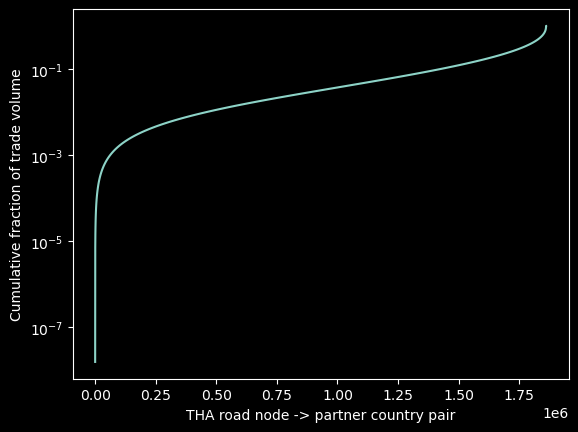

In [14]:
f, ax = plt.subplots()
ax.step(range(len(od)), np.cumsum(od.volume_tons.sort_values()) / np.sum(od.volume_tons))
ax.set_ylabel("Cumulative fraction of trade volume")
ax.set_xlabel("THA road node -> partner country pair")
ax.set_yscale("log")

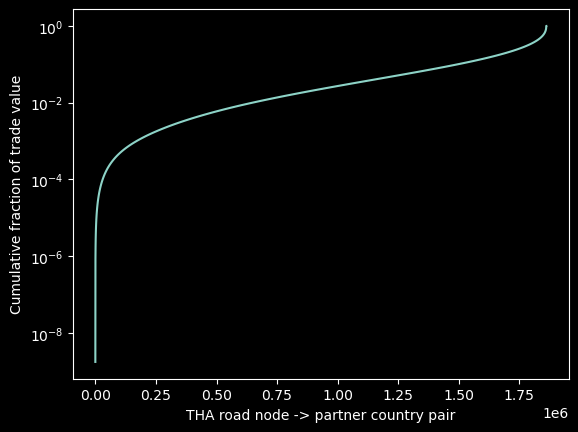

In [15]:
f, ax = plt.subplots()
ax.step(range(len(od)), np.cumsum(od.value_kusd.sort_values()) / np.sum(od.value_kusd))
ax.set_ylabel("Cumulative fraction of trade value")
ax.set_xlabel("THA road node -> partner country pair")
ax.set_yscale("log")